#### **Density Profile Measurements**:

Notebook for calculation of 2D and 3D density profiles of galaxies, dark matter, and gas.

##### **Load Catalog Data:**

Load catalog data in manner used throughout this [tutorial](https://www.tng-project.org/data/docs/scripts/).
* Clone [illustris_python](https://github.com/illustristng/illustris_python) repo which has nice functions for loading halos
* Download group, snapshot, and offset [catalogs](https://www.tng-project.org/data/downloads/TNG100-1/) for a particular snapshot (66 in this notebook)

Follow naming conventions for folder hierarchy as used throughout tutorial linked above (replacing with simulation name and snapshot index when appropriate) and then all of the loadHalo, loadSubhalo, etc. functions from the illustris_python repo should work.

In [1]:
import numpy as np
import illustris_python as il
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle
import seaborn as sns
import h5py
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u

sns.set(style = "ticks")
pi = np.pi

%config IPCompleter.greedy = True
%config InlineBackend.figure_format ='retina'

basePath = './TNG-100_3/outputs/'
snapshot_ind = 66

# Load header file and halo group catalog
header = il.groupcat.loadHeader(basePath, snapshot_ind)

halo_grp_fields = ['GroupCM', 'GroupMass', 'Group_R_Crit200', 'Group_R_Mean200']
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind, fields=halo_grp_fields)

# Get and print some cosmological info
boxsize = header['BoxSize'] # kpc/h
redshift = header['Redshift']
H = cosmo.H(redshift)
conv_fac = 100/(H.value*1000) # Multiplicative factor to convert from kpc/h to Mpc

print("Snapshot Num: "+str(snapshot_ind))
print("Snapshot Boxsize: "+str(boxsize)+" [kpc/h]")
print("Snapshot Redshift: "+str(redshift))
print("Total Number of Halos in Snapshot: "+str(halo_grp['count']))

Snapshot Num: 66
Snapshot Boxsize: 75000.0 [kpc/h]
Snapshot Redshift: 0.524565820433923
Total Number of Halos in Snapshot: 138061


##### **Load a Halo:**

Load a particular dark matter halo and plot the gas and dark matter distribution within the halo. All positions are converted to Mpc.

<Figure size 432x288 with 0 Axes>

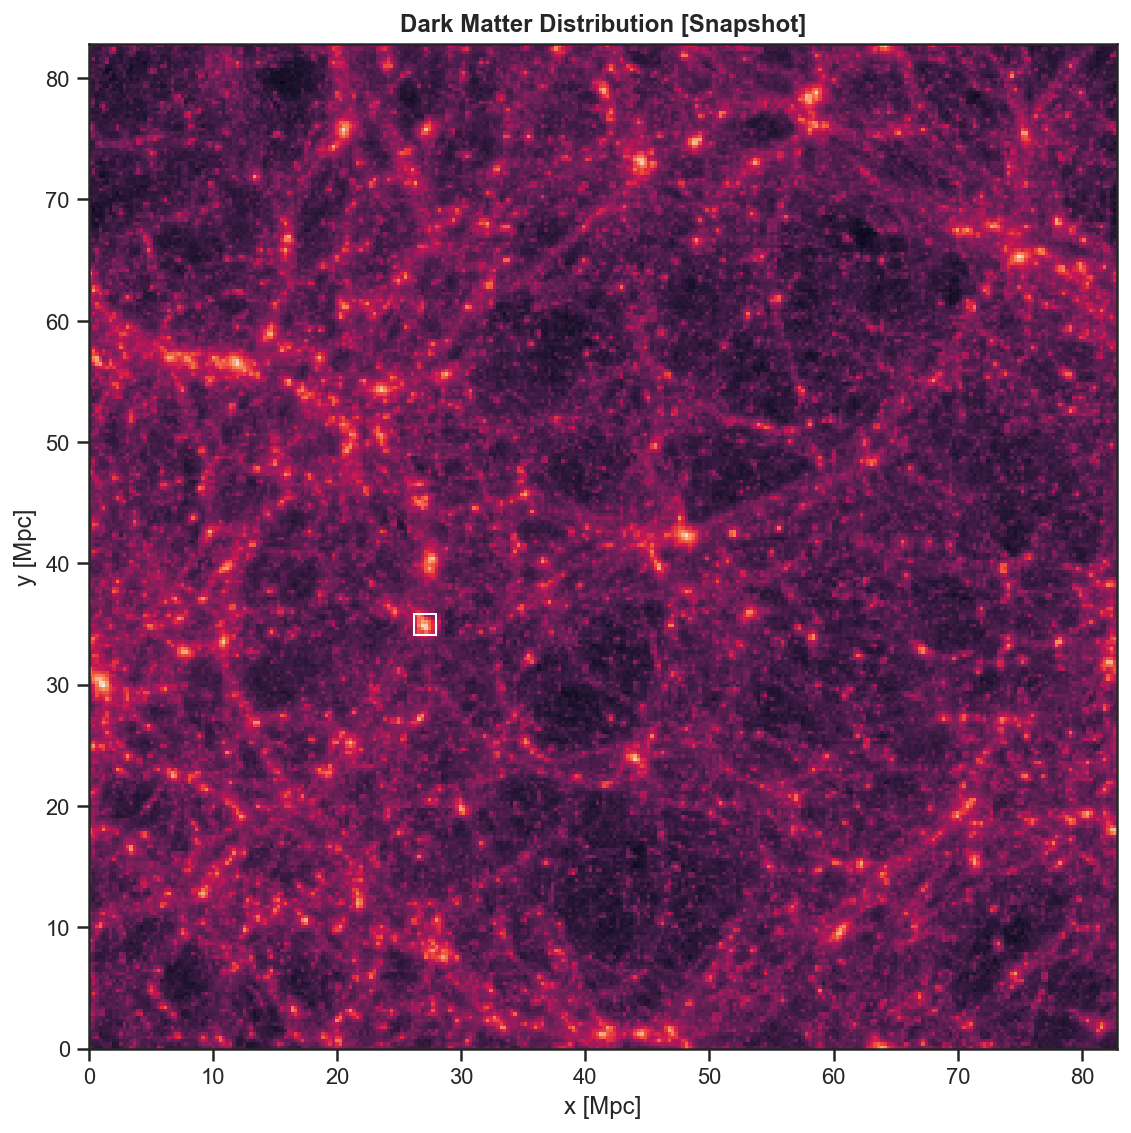

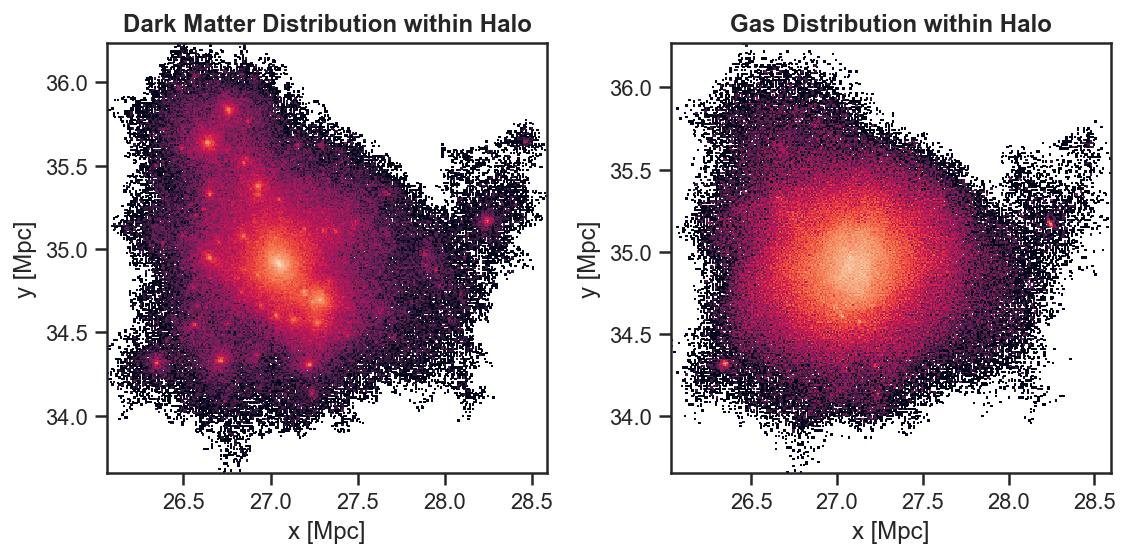

In [2]:
halo_ind = 3 # Which halo to analyze

assert(halo_ind >= 0 and halo_ind < halo_grp['count']) 

halo_cm = halo_grp['GroupCM'][halo_ind]*conv_fac
halo_gas = il.snapshot.loadHalo(basePath, snapshot_ind, halo_ind, 'gas')
halo_dm = il.snapshot.loadHalo(basePath, snapshot_ind, halo_ind,'dm')

dm_pos = il.snapshot.loadSubset(basePath, snapshot_ind, 'dm', ['Coordinates'])*conv_fac
halo_gas_pos = halo_gas['Coordinates']*conv_fac
halo_dm_pos = halo_dm['Coordinates']*conv_fac
halo_R_Mean200 = halo_grp['Group_R_Mean200'][snapshot_ind]*conv_fac

# Plot dark matter distribution
plt.figure(1)
plt.figure(figsize=(8, 8))
plt.hist2d(dm_pos[:,0], dm_pos[:,1], norm=colors.LogNorm(), bins=300)

# Plot box around selected halo
rec = plt.Rectangle((halo_cm[0]-1.5*halo_R_Mean200, halo_cm[1]-1.5*halo_R_Mean200), 
                    3*halo_R_Mean200, 3*halo_R_Mean200, ec="white", fill=None)
plt.gca().add_patch(rec)

plt.xlim(np.array([0,75000])*conv_fac)
plt.ylim(np.array([0,75000])*conv_fac)
plt.xlabel('x [Mpc]')
plt.ylabel('y [Mpc]')
plt.title("Dark Matter Distribution [Snapshot]", fontweight="bold")
plt.tight_layout()

# Plot gas and dark matter particle distributions within second halo
plt.figure(2)
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist2d(halo_dm_pos[:,0], halo_dm_pos[:,1], norm=colors.LogNorm(), bins=300)
plt.xlabel('x [Mpc]')
plt.ylabel('y [Mpc]')
plt.title("Dark Matter Distribution within Halo", fontweight="bold")

plt.subplot(1,2,2)
plt.hist2d(halo_gas_pos[:,0], halo_gas_pos[:,1], norm=colors.LogNorm(), bins=300)
plt.xlabel('x [Mpc]')
plt.ylabel('y [Mpc]')
plt.title("Gas Distribution within Halo", fontweight="bold")

plt.tight_layout()

##### **Compute Halo Density Profile:**

Compute 2D and 3D denstiy profiles of the dark matter and gas within a halo.

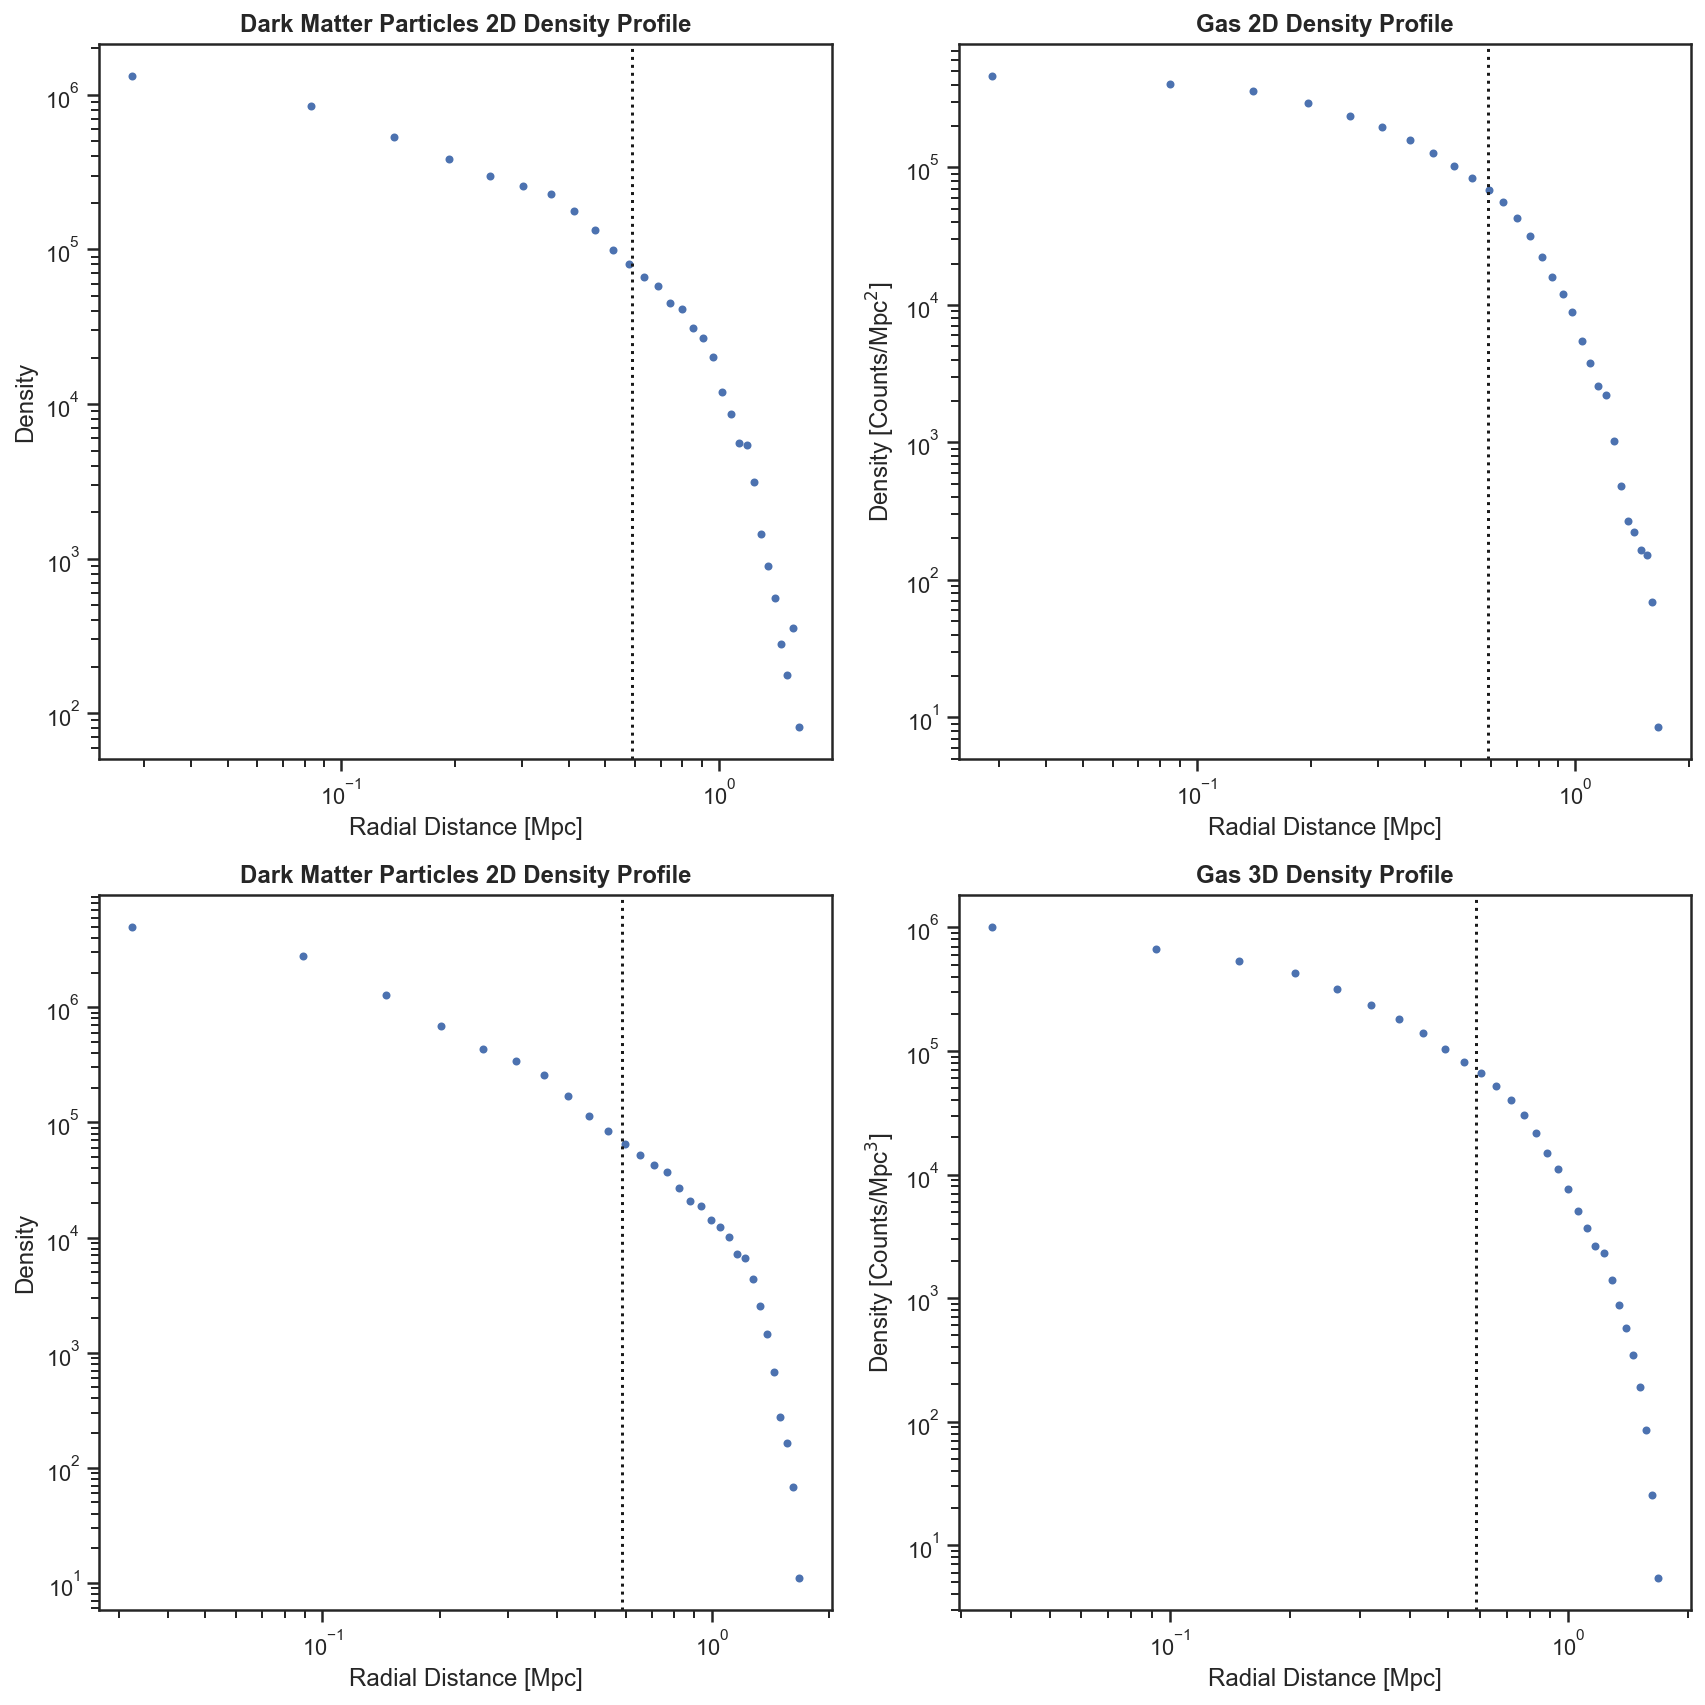

In [3]:
def compute_2D_density_profile(positions, halo_cm, n_res):
    """
    Inputs:
    positions (n*2 array): x and y positions of particles
    halo_cm (tuple): x and y position of halo cm (Mpc)
    n_res (int): number of radial bins to average over
    
    Returns:
    average_bin_radius (array): average radial position of each density bin (Mpc)
    sigma (array): density of each radial bin (Counts/Mpc^2)
    """

    # Verify input has correct shape
    assert(len(positions.T==2))
    assert(len(halo_cm)==2)

    dev = positions-halo_cm # Deviation from cm

    r = np.linalg.norm(dev, axis=1)
    
    counts, r_edges = np.histogram(r, n_res)
    dr = r_edges[1]-r_edges[0]
    
    average_bin_radius = 1/2*(r_edges[1:]+r_edges[0:-1])
    dA = 2*np.pi*average_bin_radius*dr

    sigma = counts/dA
    
    return average_bin_radius, sigma


def compute_3D_density_profile(positions, halo_cm, n_res):
    """
    Inputs:
    positions (n*3 array): x, y, and z positions of particles
    halo_cm (tuple): x and y position of halo cm (Mpc)
    n_res (int): number of radial bins to average over
    
    Returns:
    average_bin_radius (array): average radial position of each density bin (Mpc)
    rho (array): density of each radial bin (Counts/Mpc^3)
    """
    
    # Verify input has correct shape
    assert(len(positions.T==3))
    assert(len(halo_cm)==3)
    
    dev = positions-halo_cm # Deviation from cm
    r = np.linalg.norm(dev, axis=1)
    
    counts, r_edges = np.histogram(r, n_res)
    dr = r_edges[1]-r_edges[0]
    
    average_bin_radius = 1/2*(r_edges[1:]+r_edges[0:-1])
    dV = 4*np.pi*average_bin_radius**2*dr

    rho = counts/dV
    
    return average_bin_radius, rho


# Compute 2D density profile using x and y postions
halo_cm_xy = (halo_cm[0], halo_cm[1])
n_bins = 30
r_dm, sigma_dm = compute_2D_density_profile(halo_dm_pos[:,0:2], halo_cm_xy, n_bins)
r_gas, sigma_gas = compute_2D_density_profile(halo_gas_pos[:,0:2], halo_cm_xy, n_bins)

# Compute 3D density profile using x, y, and z positions
halo_cm_xyz = (halo_cm[0], halo_cm[1], halo_cm[2])
n_bins = 30
r_dm_3D, rho_dm_3D = compute_3D_density_profile(halo_dm_pos, halo_cm_xyz, n_bins)
r_gas_3D, rho_gas_3D = compute_3D_density_profile(halo_gas_pos, halo_cm_xyz, n_bins)

plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.plot(r_dm, sigma_dm,'.')
plt.title("Dark Matter Particles 2D Density Profile", fontweight="bold")
plt.axvline(halo_R_Mean200, color="k", linestyle=":")
plt.xlabel("Radial Distance [Mpc]")
plt.ylabel("Density")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2,2,2)
plt.plot(r_gas, sigma_gas,'.')
plt.axvline(halo_R_Mean200, color="k", linestyle=":")
plt.title("Gas 2D Density Profile", fontweight="bold")
plt.xlabel("Radial Distance [Mpc]")
plt.ylabel(r"Density [Counts/Mpc$^2$]")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2,2,3)
plt.plot(r_dm_3D, rho_dm_3D,'.')
plt.axvline(halo_R_Mean200, color="k", linestyle=":")
plt.title("Dark Matter Particles 2D Density Profile", fontweight="bold")
plt.xlabel("Radial Distance [Mpc]")
plt.ylabel("Density")
plt.xscale("log")
plt.yscale("log")

plt.subplot(2,2,4)
plt.plot(r_gas_3D, rho_gas_3D, '.')
plt.axvline(halo_R_Mean200, color="k", linestyle=":")
plt.title("Gas 3D Density Profile", fontweight="bold")
plt.xlabel("Radial Distance [Mpc]")
plt.ylabel(r"Density [Counts/Mpc$^3$]")
plt.xscale("log")
plt.yscale("log")

plt.tight_layout()

##### **Average Density Profiles in Mass Bins:**

<font color='red'>TODO</font>